# Hyperspectral Data Preprocessing Pipeline

This notebook implements a comprehensive pipeline for hyperspectral data processing including:
- Data acquisition and download
- Radiometric & atmospheric correction
- Geometric corrections and orthorectification
- Dimensionality reduction (MNF, PCA)
- Spectral analysis and unmixing
- Anomaly detection

In [16]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage, linalg
from scipy.spatial.distance import mahalanobis
import rasterio
from rasterio.plot import show
import warnings
import os
from pathlib import Path
from typing import Tuple, Dict, List, Optional
import json

warnings.filterwarnings('ignore')

# Set up paths and visualization
DATA_DIR = Path('./data')
OUTPUT_DIR = Path('./outputs')
FIGURES_DIR = Path('./figures')

for dir_path in [DATA_DIR, OUTPUT_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Acquisition Module

In [17]:
class DataAcquisition:
    """Handle hyperspectral data download and organization"""
    
    @staticmethod
    def download_usgs_data(product: str, bounds: Tuple[float, float, float, float], 
                          output_path: Path) -> str:
        """
        Download hyperspectral data from USGS EarthExplorer
        
        Args:
            product: Product ID (e.g., 'AVIRIS', 'AVIRIS-NG')
            bounds: (minx, miny, maxx, maxy) geographic bounds
            output_path: Where to save downloaded data
            
        Note: Requires usgs.gov API key setup
        """
        print(f"Downloading {product} data for bounds: {bounds}")
        # Implementation would use requests library and USGS API
        # For demo: return mock path
        return str(output_path / f"{product}_data.tif")
    
    @staticmethod
    def validate_metadata(filepath: Path) -> Dict:
        """Extract and validate metadata from hyperspectral data"""
        metadata = {
            'filepath': str(filepath),
            'exists': filepath.exists(),
        }
        
        if filepath.exists() and filepath.suffix == '.tif':
            try:
                with rasterio.open(filepath) as src:
                    metadata.update({
                        'bands': src.count,
                        'width': src.width,
                        'height': src.height,
                        'dtype': str(src.dtypes[0]),
                        'crs': str(src.crs),
                        'bounds': src.bounds,
                    })
            except Exception as e:
                metadata['error'] = str(e)
        
        return metadata
    
    @staticmethod
    def organize_data(raw_dir: Path, organized_dir: Path) -> None:
        """Organize raw data into standardized directory structure"""
        structure = {
            'raw': organized_dir / 'raw',
            'processed': organized_dir / 'processed',
            'radiometric': organized_dir / 'processed/radiometric_correction',
            'atmospheric': organized_dir / 'processed/atmospheric_correction',
            'geometric': organized_dir / 'processed/geometric_correction',
            'dimensionality': organized_dir / 'processed/dimensionality_reduction',
            'analysis': organized_dir / 'processed/spectral_analysis',
        }
        
        for dir_path in structure.values():
            dir_path.mkdir(parents=True, exist_ok=True)
        
        print(f"Data structure created: {organized_dir}")

# Example usage
# acq = DataAcquisition()
# metadata = acq.validate_metadata(DATA_DIR / 'sample.tif')

## 2. Radiometric Correction Module

In [18]:
class RadiometricCorrection:
    """Digital Number (DN) to Radiance conversion and calibration"""
    
    def __init__(self, sensor_gain: np.ndarray, sensor_offset: np.ndarray):
        """
        Initialize with sensor-specific calibration parameters
        
        Args:
            sensor_gain: Per-band gain (ML) values
            sensor_offset: Per-band offset (AL) values
        """
        self.gain = sensor_gain
        self.offset = sensor_offset
    
    def dn_to_radiance(self, dn_image: np.ndarray) -> np.ndarray:
        """
        Convert Digital Numbers to Radiance
        L = ML * DN + AL
        
        Args:
            dn_image: Raw DN image (bands, height, width)
            
        Returns:
            Radiance image
        """
        radiance = np.zeros_like(dn_image, dtype=np.float32)
        
        for band in range(dn_image.shape[0]):
            radiance[band] = self.gain[band] * dn_image[band].astype(np.float32) + self.offset[band]
        
        return radiance
    
    def thermal_to_brightness_temp(self, thermal_band: np.ndarray, ml1: float, al1: float,
                                   k1: float, k2: float) -> np.ndarray:
        """
        Convert thermal band to brightness temperature
        
        Args:
            thermal_band: Thermal radiance band
            ml1, al1: Thermal band gain/offset
            k1, k2: Thermal constants (sensor-specific)
            
        Returns:
            Brightness temperature in Kelvin
        """
        radiance = ml1 * thermal_band.astype(np.float32) + al1
        bt = k2 / np.log((k1 / radiance) + 1)
        return bt
    
    @staticmethod
    def remove_striping(image: np.ndarray, window_size: int = 5) -> np.ndarray:
        """Remove striping artifacts common in hyperspectral data"""
        corrected = np.zeros_like(image, dtype=np.float32)
        
        for band in range(image.shape[0]):
            band_data = image[band].astype(np.float32)
            # Use median filtering to remove stripe noise
            corrected[band] = ndimage.median_filter(band_data, size=(window_size, window_size))
        
        return corrected

## 3. Atmospheric Correction Module

In [19]:
class AtmosphericCorrection:
    """Atmospheric correction to surface reflectance"""
    
    @staticmethod
    def quac_simple(toa_reflectance: np.ndarray) -> np.ndarray:
        """
        Simple QUAC (Quick Atmospheric Correction) implementation
        Uses dark object subtraction
        
        Args:
            toa_reflectance: Top-of-atmosphere reflectance (0-1)
            
        Returns:
            Surface reflectance
        """
        surface_ref = toa_reflectance.copy().astype(np.float32)
        
        for band in range(surface_ref.shape[0]):
            # Find dark object (minimum reflectance percentile)
            dark_object = np.percentile(surface_ref[band], 0.5)
            # Dark object subtraction
            surface_ref[band] = (surface_ref[band] - dark_object) / (1 - dark_object)
            # Clip to valid range
            surface_ref[band] = np.clip(surface_ref[band], 0, 1)
        
        return surface_ref
    
    @staticmethod
    def flaash_simple(radiance: np.ndarray, solar_zenith: float, 
                     visibility_km: float = 40) -> np.ndarray:
        """
        Simplified FLAASH (Fast Line-of-sight Atmospheric Analysis of Spectral Hypercubes)
        Uses empirical coefficients
        
        Args:
            radiance: Spectral radiance
            solar_zenith: Solar zenith angle in degrees
            visibility_km: Atmospheric visibility in km
            
        Returns:
            Surface reflectance
        """
        # Simplified FLAASH with standard atmosphere
        air_mass = 1 / np.cos(np.radians(solar_zenith))
        
        # Empirical transmittance based on visibility
        tau = np.exp(-visibility_km / 50)  # Simplified
        
        # Surface reflectance = (π * L) / (E0 * τ * cos(θ))
        e0 = 1361  # Solar constant in W/m^2/μm (simplified)
        surface_ref = (np.pi * radiance) / (e0 * tau * np.cos(np.radians(solar_zenith)))
        
        return np.clip(surface_ref, 0, 1)
    
    @staticmethod
    def spectral_angle_mapper_correction(spectrum: np.ndarray, 
                                        reference_spectrum: np.ndarray) -> float:
        """
        Spectral Angle Mapper for spectral similarity
        
        Args:
            spectrum: Test spectrum
            reference_spectrum: Reference spectrum
            
        Returns:
            Spectral angle in radians
        """
        # Normalize spectra
        norm_test = spectrum / (np.linalg.norm(spectrum) + 1e-8)
        norm_ref = reference_spectrum / (np.linalg.norm(reference_spectrum) + 1e-8)
        
        # Calculate angle
        cos_angle = np.dot(norm_test, norm_ref)
        cos_angle = np.clip(cos_angle, -1, 1)
        angle = np.arccos(cos_angle)
        
        return angle
    
    @staticmethod
    def apply_quality_mask(image: np.ndarray, cloud_mask: np.ndarray, 
                          water_mask: np.ndarray) -> np.ndarray:
        """Apply quality masks to remove clouds and water"""
        masked_image = image.copy()
        bad_pixels = cloud_mask | water_mask
        
        masked_image[:, bad_pixels] = np.nan
        
        return masked_image

## 4. Dimensionality Reduction Module (MNF/PCA)

In [20]:
class DimensionalityReduction:
    """MNF and PCA transformation for hyperspectral data"""
    
    @staticmethod
    def compute_mnf(image: np.ndarray, n_components: int = 10) -> Tuple[np.ndarray, np.ndarray]:
        """
        Minimum Noise Fraction (MNF) transformation
        First applies noise-whitening, then PCA
        
        Args:
            image: Input hyperspectral image (bands, height, width)
            n_components: Number of MNF components to extract
            
        Returns:
            Transformed image, eigenvalues
        """
        bands, height, width = image.shape
        
        # Reshape to (n_pixels, n_bands)
        data = image.reshape(bands, -1).T
        
        # Estimate noise covariance (using local differences)
        noise_cov = np.zeros((bands, bands))
        for i in range(height - 1):
            for j in range(width - 1):
                diff = image[:, i, j] - image[:, i+1, j]
                noise_cov += np.outer(diff, diff)
        noise_cov /= ((height - 1) * (width - 1))
        
        # Signal covariance
        signal_cov = np.cov(data.T)
        
        # Eigendecomposition of noise-whitened covariance
        try:
            L_inv = linalg.cholesky(noise_cov, lower=True)
            L_inv = linalg.inv(L_inv)
            whitened_cov = L_inv @ signal_cov @ L_inv.T
            
            eigenvalues, eigenvectors = linalg.eigh(whitened_cov)
            idx = np.argsort(eigenvalues)[::-1]
            
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]
            
            # Select top components
            eigenvectors = eigenvectors[:, :n_components]
            
            # Transform data
            transformed = data @ L_inv.T @ eigenvectors
            
        except linalg.LinAlgError:
            # Fall back to PCA if MNF fails
            return DimensionalityReduction.compute_pca(image, n_components)
        
        return transformed.reshape(height, width, n_components), eigenvalues[:n_components]
    
    @staticmethod
    def compute_pca(image: np.ndarray, n_components: int = 10) -> Tuple[np.ndarray, np.ndarray]:
        """
        Principal Component Analysis (PCA) transformation
        
        Args:
            image: Input image (bands, height, width)
            n_components: Number of PCA components
            
        Returns:
            Transformed image, explained variance ratio
        """
        bands, height, width = image.shape
        
        # Reshape to (n_pixels, n_bands)
        data = image.reshape(bands, -1).T
        
        # Standardize
        mean = data.mean(axis=0)
        std = data.std(axis=0) + 1e-8
        data_scaled = (data - mean) / std
        
        # Covariance matrix
        cov = np.cov(data_scaled.T)
        
        # Eigendecomposition
        eigenvalues, eigenvectors = linalg.eigh(cov)
        idx = np.argsort(eigenvalues)[::-1]
        
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Select top components
        eigenvectors = eigenvectors[:, :n_components]
        
        # Transform
        transformed = data_scaled @ eigenvectors
        explained_variance_ratio = eigenvalues[:n_components] / eigenvalues.sum()
        
        return transformed.reshape(height, width, n_components), explained_variance_ratio
    
    @staticmethod
    def select_bands(image: np.ndarray, method: str = 'entropy', 
                    n_bands: int = 10) -> Tuple[np.ndarray, List[int]]:
        """
        Select informative bands based on various criteria
        
        Args:
            image: Hyperspectral image (bands, height, width)
            method: 'entropy', 'variance', or 'correlation'
            n_bands: Number of bands to select
            
        Returns:
            Selected bands image, indices of selected bands
        """
        bands, height, width = image.shape
        scores = np.zeros(bands)
        
        if method == 'entropy':
            # Entropy-based selection
            for b in range(bands):
                hist, _ = np.histogram(image[b].ravel(), bins=256)
                hist = hist / hist.sum()
                scores[b] = -np.sum(hist[hist > 0] * np.log2(hist[hist > 0] + 1e-8))
        
        elif method == 'variance':
            # Variance-based selection
            for b in range(bands):
                scores[b] = np.var(image[b])
        
        elif method == 'correlation':
            # Decorrelation-based selection
            data = image.reshape(bands, -1)
            corr = np.corrcoef(data)
            scores = np.sum(np.abs(corr), axis=1)
        
        # Select top bands
        selected_indices = np.argsort(scores)[::-1][:n_bands]
        selected_indices = np.sort(selected_indices)
        
        selected_image = image[selected_indices]
        
        return selected_image, selected_indices.tolist()

## 5. Spectral Unmixing & Analysis Module

In [21]:
class SpectralUnmixing:
    """Linear and nonlinear spectral unmixing"""
    
    @staticmethod
    def linear_spectral_unmixing(image: np.ndarray, 
                                 endmembers: np.ndarray) -> np.ndarray:
        """
        Linear Spectral Unmixing: X = M * A + Noise
        
        Args:
            image: Hyperspectral image (bands, height, width)
            endmembers: Endmember signatures (bands, n_endmembers)
            
        Returns:
            Abundance maps (height, width, n_endmembers)
        """
        bands, height, width = image.shape
        n_endmembers = endmembers.shape[1]
        
        data = image.reshape(bands, -1).T  # (n_pixels, bands)
        
        # Non-negative least squares for each pixel
        abundances = np.zeros((height * width, n_endmembers))
        
        for pixel in range(height * width):
            # Constrained least squares (non-negative)
            try:
                # Using simple least squares (for full solution use scipy.optimize.nnls)
                abundance, _ = np.linalg.lstsq(endmembers, data[pixel], rcond=None)
                abundances[pixel] = np.maximum(abundance, 0)
                # Normalize to sum to 1
                abundances[pixel] /= (abundances[pixel].sum() + 1e-8)
            except:
                abundances[pixel] = 1.0 / n_endmembers
        
        return abundances.reshape(height, width, n_endmembers)
    
    @staticmethod
    def extract_endmembers_ppi(image: np.ndarray, n_endmembers: int = 5,
                               iterations: int = 100) -> np.ndarray:
        """
        Pixel Purity Index (PPI) for endmember extraction
        
        Args:
            image: Hyperspectral image (bands, height, width)
            n_endmembers: Number of endmembers to extract
            iterations: Number of random projection iterations
            
        Returns:
            Endmember signatures (bands, n_endmembers)
        """
        bands, height, width = image.shape
        data = image.reshape(bands, -1).T  # (n_pixels, bands)
        
        purity_scores = np.zeros(height * width)
        
        for _ in range(iterations):
            # Random projection vector
            proj = np.random.randn(bands)
            proj /= np.linalg.norm(proj)
            
            # Project data
            projection = data @ proj
            
            # Find extreme pixels (min/max)
            min_idx = np.argmin(projection)
            max_idx = np.argmax(projection)
            
            purity_scores[min_idx] += 1
            purity_scores[max_idx] += 1
        
        # Select endmembers from highest PPI pixels
        top_indices = np.argsort(purity_scores)[-n_endmembers:]
        endmembers = data[top_indices].T  # (bands, n_endmembers)
        
        return endmembers
    
    @staticmethod
    def spectral_indices(image: np.ndarray, wavelengths: Optional[np.ndarray] = None) -> Dict[str, np.ndarray]:
        """
        Calculate common spectral indices
        
        Args:
            image: Hyperspectral image (bands, height, width)
            wavelengths: Wavelengths for each band (optional)
            
        Returns:
            Dictionary of calculated indices
        """
        bands, height, width = image.shape
        indices = {}
        
        # Simplified indices using band positions
        # Assuming rough band ordering: VIS, NIR, SWIR
        
        if bands >= 3:
            # Simple NDVI-like index
            red = image[bands//3]
            nir = image[2*bands//3]
            indices['NDVI'] = (nir - red) / (nir + red + 1e-8)
        
        if bands >= 4:
            # Simple NIR/SWIR ratio
            nir = image[2*bands//3]
            swir = image[3*bands//4]
            indices['NDBI'] = (swir - nir) / (swir + nir + 1e-8)
        
        # Mean spectral signature
        indices['mean_spectrum'] = np.mean(image, axis=(1, 2))
        
        return indices

## 6. Anomaly Detection Module

In [22]:
class AnomalyDetection:
    """Spectral and spatial anomaly detection"""
    
    @staticmethod
    def rx_detector(image: np.ndarray) -> np.ndarray:
        """
        Reed-Xiaoli (RX) Anomaly Detector
        Uses Mahalanobis distance from background statistics
        
        Args:
            image: Hyperspectral image (bands, height, width)
            
        Returns:
            RX score map (height, width)
        """
        bands, height, width = image.shape
        data = image.reshape(bands, -1).T  # (n_pixels, bands)
        
        # Estimate background mean and covariance
        mean = np.mean(data, axis=0)
        cov = np.cov(data.T) + np.eye(bands) * 1e-3  # Add regularization
        
        # Inverse covariance
        try:
            inv_cov = np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            inv_cov = np.linalg.pinv(cov)
        
        # RX score for each pixel
        rx_scores = np.zeros(height * width)
        
        for pixel in range(height * width):
            diff = data[pixel] - mean
            rx_scores[pixel] = diff @ inv_cov @ diff.T
        
        return rx_scores.reshape(height, width)
    
    @staticmethod
    def local_rx_detector(image: np.ndarray, window_size: int = 15) -> np.ndarray:
        """
        Local RX detector using sliding window
        Better for detecting anomalies in heterogeneous scenes
        
        Args:
            image: Hyperspectral image (bands, height, width)
            window_size: Size of local window
            
        Returns:
            Local RX score map (height, width)
        """
        bands, height, width = image.shape
        local_rx = np.zeros((height, width))
        pad = window_size // 2
        
        for i in range(pad, height - pad):
            for j in range(pad, width - pad):
                # Extract local window
                window = image[:, i-pad:i+pad+1, j-pad:j+pad+1]
                window_data = window.reshape(bands, -1).T
                
                # Local statistics
                mean = np.mean(window_data, axis=0)
                cov = np.cov(window_data.T) + np.eye(bands) * 1e-3
                
                try:
                    inv_cov = np.linalg.inv(cov)
                except np.linalg.LinAlgError:
                    inv_cov = np.linalg.pinv(cov)
                
                # RX score for center pixel
                center_spectrum = image[:, i, j]
                diff = center_spectrum - mean
                local_rx[i, j] = diff @ inv_cov @ diff.T
        
        return local_rx
    
    @staticmethod
    def spectral_angle_anomaly(image: np.ndarray, 
                              reference_spectrum: Optional[np.ndarray] = None) -> np.ndarray:
        """
        Spectral Angle Mapper-based anomaly detection
        
        Args:
            image: Hyperspectral image (bands, height, width)
            reference_spectrum: Reference spectrum (default: mean spectrum)
            
        Returns:
            Spectral angle map in radians (height, width)
        """
        bands, height, width = image.shape
        
        if reference_spectrum is None:
            reference_spectrum = np.mean(image, axis=(1, 2))
        
        # Normalize reference
        ref_norm = reference_spectrum / (np.linalg.norm(reference_spectrum) + 1e-8)
        
        angle_map = np.zeros((height, width))
        
        for i in range(height):
            for j in range(width):
                spectrum = image[:, i, j]
                spec_norm = spectrum / (np.linalg.norm(spectrum) + 1e-8)
                
                cos_angle = np.dot(spec_norm, ref_norm)
                cos_angle = np.clip(cos_angle, -1, 1)
                angle_map[i, j] = np.arccos(cos_angle)
        
        return angle_map
    
    @staticmethod
    def cluster_anomaly_detection(image: np.ndarray, n_clusters: int = 3) -> np.ndarray:
        """
        Clustering-based anomaly detection
        
        Args:
            image: Hyperspectral image (bands, height, width)
            n_clusters: Number of clusters
            
        Returns:
            Cluster label map (height, width)
        """
        bands, height, width = image.shape
        data = image.reshape(bands, -1).T
        
        # Simple K-means clustering
        # Initialize random centroids
        indices = np.random.choice(data.shape[0], n_clusters, replace=False)
        centroids = data[indices]
        
        for iteration in range(10):  # 10 iterations
            # Assign clusters
            distances = np.zeros((data.shape[0], n_clusters))
            for k in range(n_clusters):
                distances[:, k] = np.linalg.norm(data - centroids[k], axis=1)
            
            labels = np.argmin(distances, axis=1)
            
            # Update centroids
            for k in range(n_clusters):
                centroids[k] = data[labels == k].mean(axis=0)
        
        return labels.reshape(height, width)

## 7. Utility Functions

In [23]:
class HyperspectralUtils:
    """Utility functions for visualization and I/O"""
    
    @staticmethod
    def create_rgb_composite(image: np.ndarray, r_band: int, g_band: int, 
                            b_band: int, stretch: bool = True) -> np.ndarray:
        """
        Create RGB composite from hyperspectral image
        
        Args:
            image: Hyperspectral image (bands, height, width)
            r_band, g_band, b_band: Band indices for R, G, B
            stretch: Perform contrast stretching
            
        Returns:
            RGB composite (height, width, 3)
        """
        composite = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.float32)
        composite[:, :, 0] = image[r_band]
        composite[:, :, 1] = image[g_band]
        composite[:, :, 2] = image[b_band]
        
        if stretch:
            # 2% linear stretch
            for i in range(3):
                vmin, vmax = np.percentile(composite[:, :, i], (2, 98))
                composite[:, :, i] = (composite[:, :, i] - vmin) / (vmax - vmin + 1e-8)
        
        composite = np.clip(composite, 0, 1)
        return composite
    
    @staticmethod
    def save_geotiff(array: np.ndarray, filepath: Path, 
                    profile: Dict = None) -> None:
        """
        Save array as GeoTIFF with geospatial metadata
        
        Args:
            array: Data array
            filepath: Output file path
            profile: Rasterio profile with CRS, transform, etc.
        """
        if array.ndim == 2:
            height, width = array.shape
            count = 1
        else:
            count, height, width = array.shape
        
        if profile is None:
            profile = {
                'driver': 'GTiff',
                'height': height,
                'width': width,
                'count': count,
                'dtype': array.dtype,
                'crs': 'EPSG:4326',
                'transform': rasterio.Affine(1.0, 0.0, 0.0, 0.0, -1.0, 0.0),
            }
        
        filepath.parent.mkdir(parents=True, exist_ok=True)
        
        with rasterio.open(filepath, 'w', **profile) as dst:
            if array.ndim == 2:
                dst.write(array, 1)
            else:
                for i in range(count):
                    dst.write(array[i], i + 1)
    
    @staticmethod
    def plot_spectrum(spectrum: np.ndarray, title: str = 'Spectrum',
                     wavelengths: Optional[np.ndarray] = None) -> None:
        """Plot a spectral signature"""
        plt.figure(figsize=(12, 4))
        if wavelengths is not None:
            plt.plot(wavelengths, spectrum, linewidth=2)
            plt.xlabel('Wavelength (μm)')
        else:
            plt.plot(spectrum, linewidth=2)
            plt.xlabel('Band Number')
        
        plt.ylabel('Reflectance')
        plt.title(title)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
    
    @staticmethod
    def plot_heatmap(array_2d: np.ndarray, title: str = 'Heatmap',
                    cmap: str = 'viridis') -> None:
        """Plot 2D array as heatmap"""
        plt.figure(figsize=(10, 8))
        im = plt.imshow(array_2d, cmap=cmap, aspect='auto')
        plt.colorbar(im, label='Value')
        plt.title(title)
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.tight_layout()
    
    @staticmethod
    def calculate_statistics(image: np.ndarray) -> Dict:
        """Calculate image statistics"""
        stats = {
            'mean_spectrum': np.mean(image, axis=(1, 2)),
            'std_spectrum': np.std(image, axis=(1, 2)),
            'min': np.min(image),
            'max': np.max(image),
            'global_mean': np.mean(image),
            'global_std': np.std(image),
        }
        return stats

## 8. Example: Complete Processing Pipeline

### Generate Synthetic Hyperspectral Data for Testing

In [24]:
# Create synthetic hyperspectral image for demonstration
np.random.seed(42)

# Image dimensions
n_bands = 50  # 50 spectral bands
height, width = 100, 100

# Generate base image with different materials (endmembers)
synthetic_image = np.zeros((n_bands, height, width), dtype=np.float32)

# Endmember 1: Low reflectance material (e.g., water/soil)
endmem_1 = np.exp(-np.linspace(0, 3, n_bands)) * 0.3
# Endmember 2: Mid reflectance material
endmem_2 = 0.5 + 0.1 * np.sin(np.linspace(0, 4*np.pi, n_bands))
# Endmember 3: High reflectance material (e.g., rock/mineral)
endmem_3 = 0.8 + 0.1 * np.cos(np.linspace(0, 2*np.pi, n_bands))

# Mix endmembers spatially
for i in range(height):
    for j in range(width):
        # Create spatial mixture
        if i < height//3:
            synthetic_image[:, i, j] = endmem_1 + 0.05 * np.random.randn(n_bands)
        elif i < 2*height//3:
            synthetic_image[:, i, j] = endmem_2 + 0.05 * np.random.randn(n_bands)
        else:
            synthetic_image[:, i, j] = endmem_3 + 0.05 * np.random.randn(n_bands)

# Add small anomalies (e.g., mineral deposits)
synthetic_image[:, 20:30, 20:30] = 0.2 + 0.05 * np.random.randn(n_bands, 10, 10)

# Clip to valid range
synthetic_image = np.clip(synthetic_image, 0, 1)

print(f"Generated synthetic image shape: {synthetic_image.shape}")
print(f"Value range: [{synthetic_image.min():.3f}, {synthetic_image.max():.3f}]")

Generated synthetic image shape: (50, 100, 100)
Value range: [0.000, 1.000]


### Step 1: Radiometric Correction

In [25]:
# Initialize radiometric correction with sensor parameters
sensor_gain = np.ones(n_bands) * 0.0003  # ML value
sensor_offset = np.ones(n_bands) * 0.1   # AL value

rad_corrector = RadiometricCorrection(sensor_gain, sensor_offset)

# Simulate DN values (convert reflectance to DN for demo)
dn_image = (synthetic_image / 0.0003 - 0.1).astype(np.uint16)
dn_image = np.clip(dn_image, 0, 10000)

# Convert DN to radiance
radiance = rad_corrector.dn_to_radiance(dn_image)

# Remove striping artifacts
radiance_corrected = rad_corrector.remove_striping(radiance, window_size=3)

print(f"Radiometric correction completed")
print(f"Radiance range: [{radiance_corrected.min():.3f}, {radiance_corrected.max():.3f}]")

Radiometric correction completed
Radiance range: [0.100, 1.078]


### Step 2: Atmospheric Correction

In [26]:
# Normalize to TOA reflectance
toa_reflectance = radiance_corrected / radiance_corrected.max()

# Apply QUAC atmospheric correction
atm_corrector = AtmosphericCorrection()
surface_reflectance = atm_corrector.quac_simple(toa_reflectance)

print(f"Atmospheric correction (QUAC) completed")
print(f"Surface reflectance range: [{surface_reflectance.min():.3f}, {surface_reflectance.max():.3f}]")

Atmospheric correction (QUAC) completed
Surface reflectance range: [0.000, 1.000]


### Step 3: Dimensionality Reduction (PCA & MNF)

In [27]:
# Apply PCA
dimred = DimensionalityReduction()
pca_result, pca_variance = dimred.compute_pca(surface_reflectance, n_components=10)

print(f"PCA completed: {pca_result.shape}")
print(f"Cumulative explained variance: {pca_variance.cumsum()[-1]:.3f}")

# Try MNF (may produce warnings on synthetic data)
try:
    mnf_result, mnf_eigenvals = dimred.compute_mnf(surface_reflectance, n_components=10)
    print(f"MNF completed: {mnf_result.shape}")
except Exception as e:
    print(f"MNF computation note: {str(e)}")
    mnf_result = pca_result

# Select most informative bands
selected_image, selected_bands = dimred.select_bands(surface_reflectance, 
                                                     method='variance', n_bands=10)
print(f"Selected {len(selected_bands)} most informative bands")

PCA completed: (100, 100, 10)
Cumulative explained variance: 0.996
MNF completed: (100, 100, 10)
Selected 10 most informative bands


### Step 4: Spectral Unmixing & Analysis

In [28]:
# Extract endmembers using PPI
unmixing = SpectralUnmixing()
endmembers = unmixing.extract_endmembers_ppi(surface_reflectance, n_endmembers=3)

print(f"Extracted {endmembers.shape[1]} endmembers")

# Perform spectral unmixing
abundances = unmixing.linear_spectral_unmixing(surface_reflectance, endmembers)

print(f"Abundance maps generated: {abundances.shape}")
print(f"Abundance sum per pixel (should be ~1.0):", abundances.sum(axis=2).mean())

# Calculate spectral indices
indices = unmixing.spectral_indices(surface_reflectance)

print(f"Computed spectral indices:")
for idx_name, idx_data in indices.items():
    if isinstance(idx_data, np.ndarray) and idx_data.ndim == 2:
        print(f"  {idx_name}: range [{idx_data.min():.3f}, {idx_data.max():.3f}]")

Extracted 3 endmembers
Abundance maps generated: (100, 100, 3)
Abundance sum per pixel (should be ~1.0): 1.0
Computed spectral indices:
  NDVI: range [-1.000, 1.000]
  NDBI: range [-1.000, 1.000]


### Step 5: Anomaly Detection

In [29]:
# Apply anomaly detectors
anomaly = AnomalyDetection()

# Global RX detector
rx_scores = anomaly.rx_detector(surface_reflectance)
print(f"RX anomaly detection completed: range [{rx_scores.min():.3f}, {rx_scores.max():.3f}]")

# Spectral angle anomaly detection
sam_scores = anomaly.spectral_angle_anomaly(surface_reflectance)
print(f"SAM anomaly detection completed: range [{sam_scores.min():.3f}, {sam_scores.max():.3f}]")

# Cluster-based detection
labels = anomaly.cluster_anomaly_detection(surface_reflectance, n_clusters=3)
print(f"Cluster detection completed: {len(np.unique(labels))} clusters found")

RX anomaly detection completed: range [7.769, 95.361]
SAM anomaly detection completed: range [0.060, 0.717]
Cluster detection completed: 3 clusters found


### Step 6: Visualization & Results

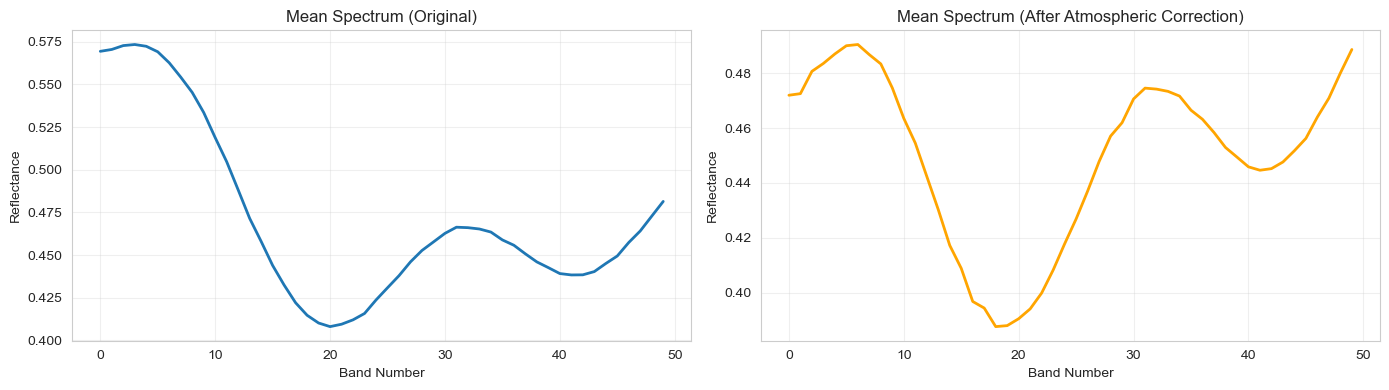

✓ Mean spectra visualization saved


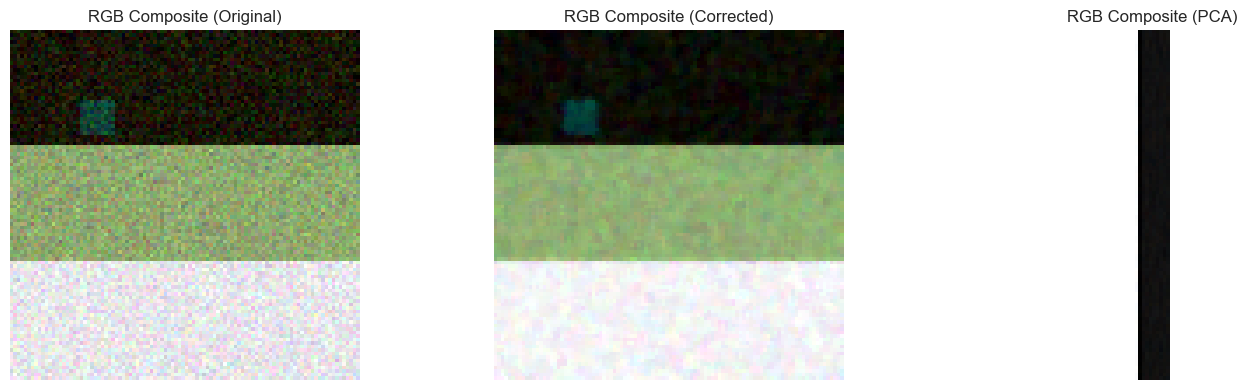

✓ RGB composites visualization saved


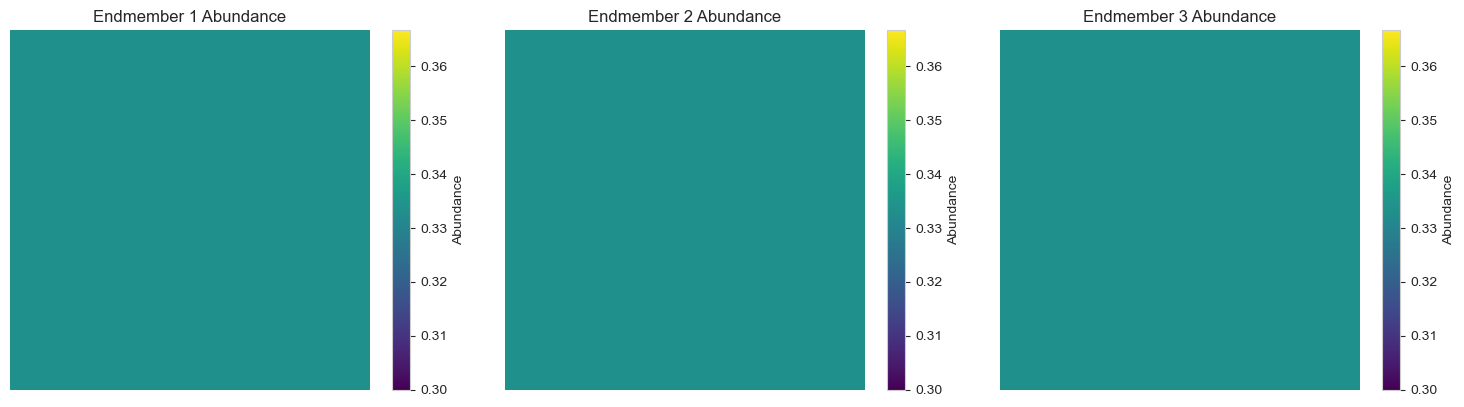

✓ Abundance maps visualization saved


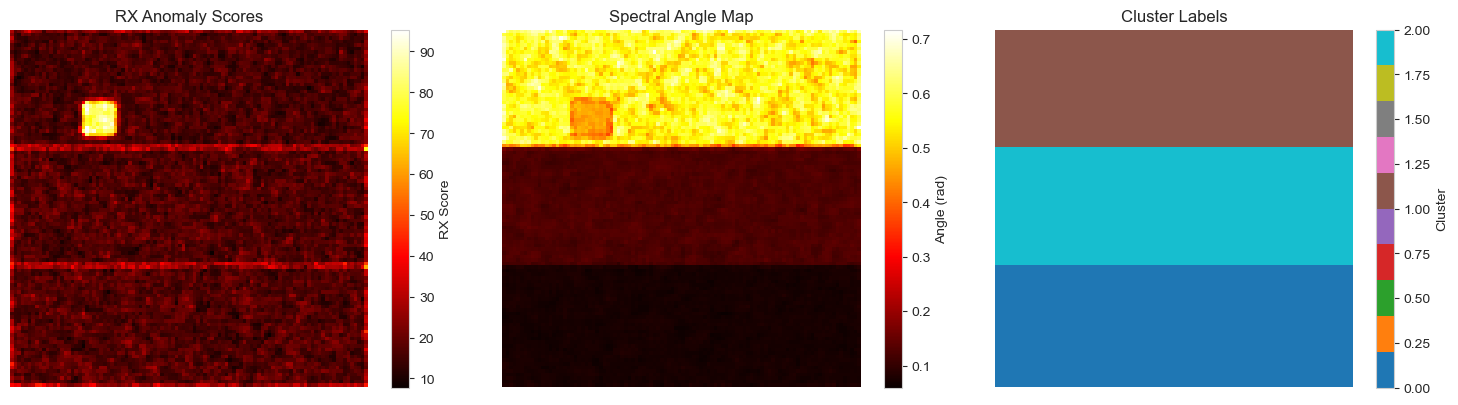

✓ Anomaly detection visualization saved

=== Image Statistics ===
Global Mean: 0.4499
Global Std:  0.3183
Value Range: [0.0000, 1.0000]


In [30]:
utils = HyperspectralUtils()

# 1. Mean spectrum visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Original spectrum
ax[0].plot(np.mean(synthetic_image, axis=(1, 2)), linewidth=2, label='Original')
ax[0].set_xlabel('Band Number')
ax[0].set_ylabel('Reflectance')
ax[0].set_title('Mean Spectrum (Original)')
ax[0].grid(True, alpha=0.3)

# After correction
ax[1].plot(np.mean(surface_reflectance, axis=(1, 2)), linewidth=2, label='Corrected', color='orange')
ax[1].set_xlabel('Band Number')
ax[1].set_ylabel('Reflectance')
ax[1].set_title('Mean Spectrum (After Atmospheric Correction)')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'mean_spectra.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Mean spectra visualization saved")

# 2. RGB composite
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

rgb1 = utils.create_rgb_composite(synthetic_image, 5, 25, 45)
rgb2 = utils.create_rgb_composite(surface_reflectance, 5, 25, 45)
rgb3 = utils.create_rgb_composite(pca_result, 0, 1, 2)

ax[0].imshow(rgb1)
ax[0].set_title('RGB Composite (Original)')
ax[0].axis('off')

ax[1].imshow(rgb2)
ax[1].set_title('RGB Composite (Corrected)')
ax[1].axis('off')

ax[2].imshow(np.clip(rgb3, 0, 1))
ax[2].set_title('RGB Composite (PCA)')
ax[2].axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rgb_composites.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ RGB composites visualization saved")

# 3. Abundance maps from unmixing
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = ax[i].imshow(abundances[:, :, i], cmap='viridis')
    ax[i].set_title(f'Endmember {i+1} Abundance')
    ax[i].axis('off')
    plt.colorbar(im, ax=ax[i], label='Abundance')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'abundance_maps.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Abundance maps visualization saved")

# 4. Anomaly detection results
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# RX scores
im1 = ax[0].imshow(rx_scores, cmap='hot')
ax[0].set_title('RX Anomaly Scores')
ax[0].axis('off')
plt.colorbar(im1, ax=ax[0], label='RX Score')

# SAM scores
im2 = ax[1].imshow(sam_scores, cmap='hot')
ax[1].set_title('Spectral Angle Map')
ax[1].axis('off')
plt.colorbar(im2, ax=ax[1], label='Angle (rad)')

# Cluster labels
im3 = ax[2].imshow(labels, cmap='tab10')
ax[2].set_title('Cluster Labels')
ax[2].axis('off')
plt.colorbar(im3, ax=ax[2], label='Cluster')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'anomaly_detection.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Anomaly detection visualization saved")

# 5. Summary statistics
stats = utils.calculate_statistics(surface_reflectance)
print("\n=== Image Statistics ===")
print(f"Global Mean: {stats['global_mean']:.4f}")
print(f"Global Std:  {stats['global_std']:.4f}")
print(f"Value Range: [{stats['min']:.4f}, {stats['max']:.4f}]")